In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom Libs
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../')))
from ridgepy.libridgewrapper.config import MAIN_CONFIG
from ridgepy.libridgewrapper.kalman_filter_mode import KalmanFilterMode
from ridgepy.libridgewrapper.kalman_filter_network import KalmanFilterNetwork

In [4]:
frequency_sample = 16000.0
start_time       = 0.0
end_time         = 0.2
time             = np.arange(start_time, end_time, 1./frequency_sample)

F           = 300.0
A           = 1.0
B           = 0.5
phase       = np.mod(2*np.pi*F*time, 2*np.pi)
observation = A*np.cos(phase) + B*np.sin(phase)

data_df = pd.DataFrame({
    'time': time,
    'phase': phase,
    'observation': observation
})

data_df.head()

,time,phase,observation
0,0.000000,0.000000,1.000000
1,0.000063,0.117810,1.051837
2,0.000125,0.235619,1.089093
3,0.000188,0.353429,1.111250
4,0.000250,0.471239,1.118002


In [5]:
# Simple example with frequencies at 50, 100, ..., 500 Hz.
# frequencies = np.arange(31.25, 8000, 31.25) ## Same as the 256 point FFT
frequencies = np.arange(50, 1000, 50)
modes = []
for frequency in frequencies:
    # The signal noise covariance is a 2x2 matrix.
    signal_noise_covariance = np.zeros((2,2))
    signal_noise_covariance[0][0] = 0.0001
    signal_noise_covariance[1][1] = 0.0001

    signal_error_covariance = np.zeros((2,2))
    signal_error_covariance[0][0] = 1.0
    signal_error_covariance[1][1] = 1.0

    # The observation noise covariance is a scalar.
    observation_noise_covariance = 10.0

    # The coefficients are a 2 X 1 matrix.
    sin_coefficient = 0.0
    cos_coefficient = 0.0

    mode = KalmanFilterMode(
        frequency,
        sin_coefficient,
        cos_coefficient,
        signal_error_covariance,
        signal_noise_covariance,
        observation_noise_covariance
    )
    modes.append(mode)

In [6]:
frequency_sample = 16000.
print(len(modes))
kf_network = KalmanFilterNetwork(modes)

19


In [7]:
time_step_data = []

for ndx in range(0, len(data_df)):

    ## Update the prior
    kf_network.prior_update(frequency_sample)

    ## Update the posterior
    kf_network.posterior_update(data_df.at[ndx, 'observation'])

    ## Change the logging below to use a dictionary
    current_parameters = kf_network.current_parameters()

    time_step_data.append(current_parameters)

results_df = pd.DataFrame(time_step_data)

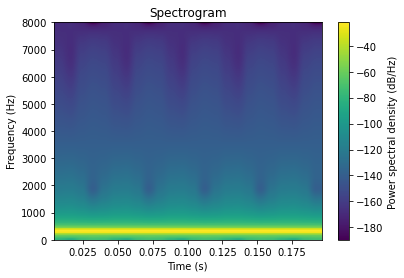

In [8]:
fs = 1./(data_df.at[1, 'time'] - data_df.at[0, 'time'])
plt.specgram(data_df['observation'], NFFT=256, Fs=fs, cmap='viridis')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Power spectral density (dB/Hz)')
plt.show()

(3200,) (3200, 19) (3200, 19)


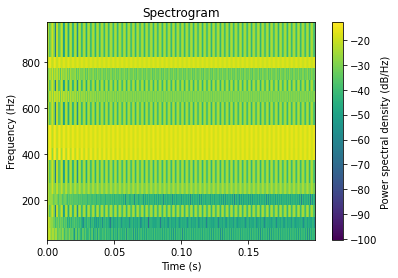

In [9]:

magnitudes = np.array(results_df['magnitudes'].apply(np.array).tolist())
magnitudes_db = np.log10(magnitudes) * 20.0

frequencies = np.array(results_df['frequencies'].apply(np.array).tolist())
times = data_df['time']
print(times.shape, frequencies.shape, magnitudes_db.shape)
plt.pcolormesh(times, frequencies.T, magnitudes_db.T, cmap='viridis')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Power spectral density (dB/Hz)')
plt.show()